# Drug dataset - Sentiment Analysis 

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
#from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

In [2]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', encoding="UTF-8")
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', encoding="UTF-8")

## Preliminary data exploration

In [3]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [4]:
# Merge train and test sets

In [5]:
df = pd.concat([df_train, df_test])

In [6]:
#df.to_excel("drugs_df.xlsx")

In [7]:
df.drugName.value_counts()

Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: drugName, Length: 3671, dtype: int64

In [8]:
df.condition.value_counts()

Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [9]:
df.describe()

,Unnamed: 0,rating,usefulCount,length
count,215063.000000,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004,84.682228
std,67007.913366,3.275554,36.346069,44.852532
min,0.000000,1.000000,0.000000,1.000000
25%,58115.500000,5.000000,6.000000,48.000000
50%,115867.000000,8.000000,16.000000,84.000000
75%,173963.500000,10.000000,36.000000,126.000000
max,232291.000000,10.000000,1291.000000,1894.000000


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
 7   length       215063 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.8+ MB


In [13]:
df.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [14]:
sum(df.condition.isnull())

1194

<AxesSubplot:xlabel='rating', ylabel='count'>

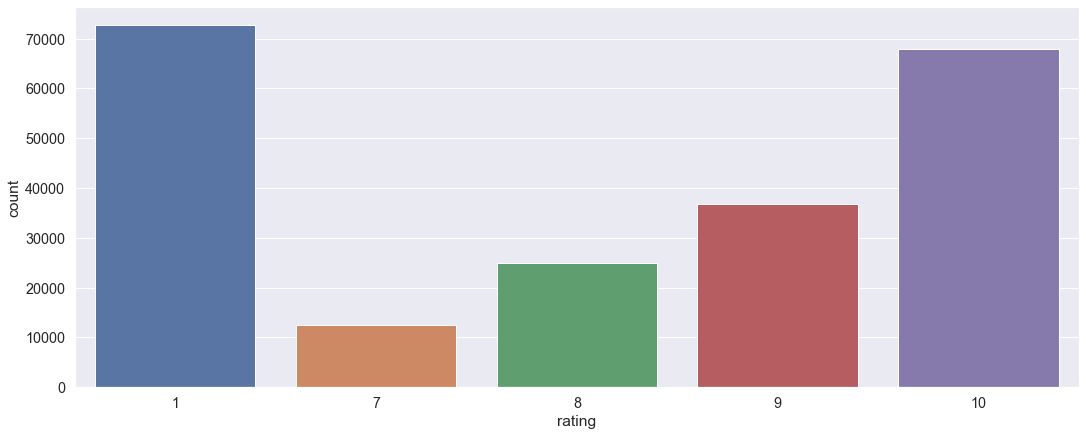

In [40]:
sns.countplot(df['rating'])

In [ ]:
# data is skewed, imalanced towards positive ratings

In [41]:
df.rating.value_counts(normalize=True)

1     0.338306
10    0.316210
9     0.170685
8     0.116459
7     0.058341
Name: rating, dtype: float64

In [42]:
# General trends in the data

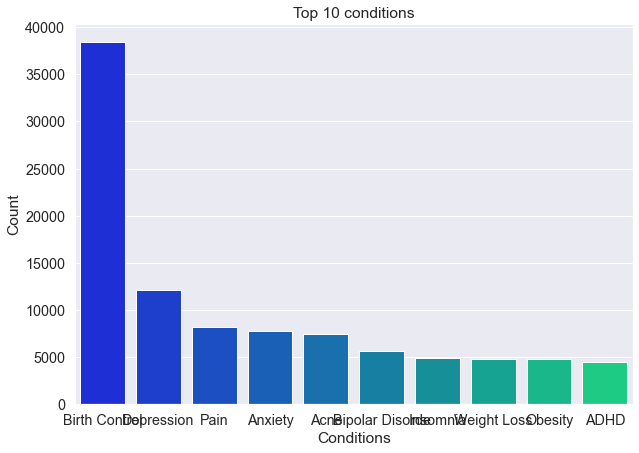

In [49]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [10, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

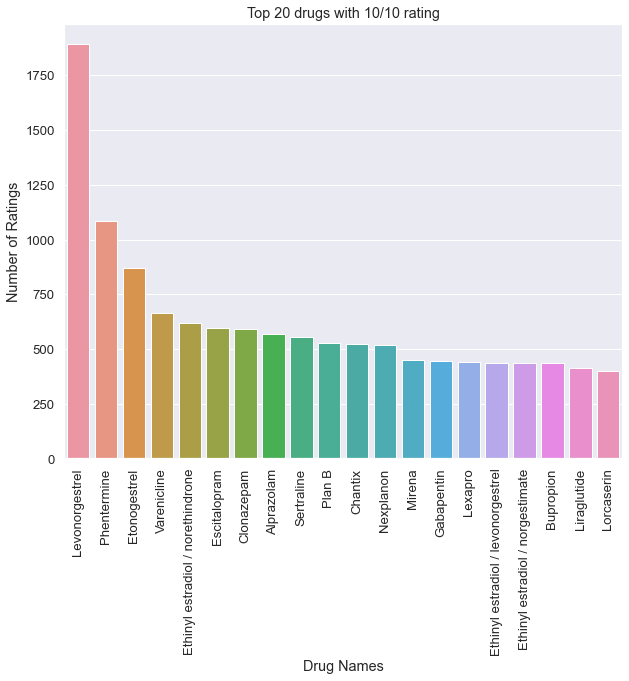

In [50]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

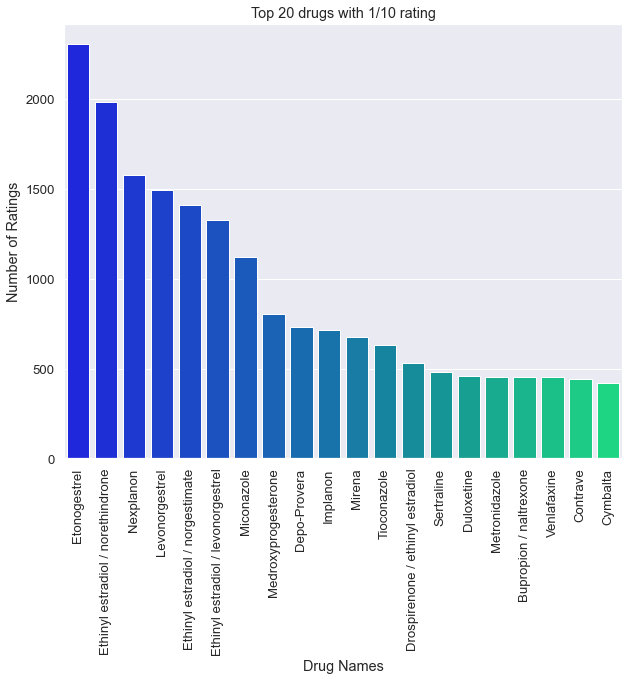

In [51]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

## Data Cleaning

### Clean 'condition' column

In [18]:
#
df["condition_clean"] = df.condition.apply(lambda x: "unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [19]:
df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

1171

In [20]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [21]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [22]:
df["condition_clean"].nunique()

837

In [23]:
#df = df.dropna()
df
# -1194 records
df.condition.fillna("unknown", axis=0, inplace=True)

### Clean reviews

In [24]:
df.drop(["Unnamed: 0","date"], axis=1, inplace=True)

In [25]:
df["review"] = df.review.str.replace("&#039;", "")
#df

In [26]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [27]:
df

,drugName,condition,review,rating,usefulCount,length,condition_clean
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",9,27,17,Left Ventricular Dysfunction
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",8,192,141,ADHD
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",5,17,134,Birth Control
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",8,10,89,Birth Control
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",9,37,124,Opiate Dependence
...,...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",10,43,97,"Breast Cancer, Prevention"
53762,Escitalopram,Anxiety,"""ive been taking lexapro (escitaploprgram) sin...",9,11,130,Anxiety
53763,Levonorgestrel,Birth Control,"""im married, 34 years old and i have no kids. ...",8,7,149,Birth Control
53764,Tapentadol,Pain,"""i was prescribed nucynta for severe neck/shou...",1,20,34,Pain


### Feature engineering: grade

In [28]:
df.rating.where(df.rating >= 6, 0, inplace=True)
df.rating.where(df.rating >= 7, 1, inplace=True)

## Creating the Corpus

In [29]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [30]:
len(corpus)

215063

In [31]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [34]:
len(corpus)

1254242

In [ ]:
# Tokenizing the corpus

In [35]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [37]:
len(list(wordfreq.keys()))

169900

In [38]:
wordfreq

{'"it': 3739,
 'has': 64045,
 'no': 77935,
 'side': 69003,
 'effect,': 698,
 'i': 896270,
 'take': 57220,
 'it': 323550,
 'in': 163300,
 'combination': 1922,
 'of': 227422,
 'bystolic': 237,
 '5': 18711,
 'mg': 16094,
 'and': 572382,
 'fish': 146,
 'oil"': 2,
 '"my': 7401,
 'son': 2519,
 'is': 148406,
 'halfway': 241,
 'through': 12033,
 'his': 4171,
 'fourth': 796,
 'week': 27580,
 'intuniv.': 58,
 'we': 9762,
 'became': 5804,
 'concerned': 1020,
 'when': 47467,
 'he': 17971,
 'began': 6454,
 'this': 159660,
 'last': 20725,
 'week,': 3226,
 'started': 53308,
 'taking': 67134,
 'the': 537936,
 'highest': 448,
 'dose': 15443,
 'will': 35417,
 'be': 52407,
 'on.': 2322,
 'for': 266451,
 'two': 27057,
 'days,': 4276,
 'could': 19477,
 'hardly': 1788,
 'get': 54571,
 'out': 41950,
 'bed,': 786,
 'was': 232186,
 'very': 51301,
 'cranky,': 39,
 'slept': 2258,
 'nearly': 3139,
 '8': 8701,
 'hours': 15705,
 'on': 177278,
 'a': 382549,
 'drive': 5991,
 'home': 3151,
 'from': 50516,
 'school': 2

### Reducing the corpus

## Running the Models